In [1]:
import pandas as pd

# CSV dosyasını yükle
df = pd.read_csv("/content/final_training_data.csv")  # path'i ihtiyacına göre düzenle

print("Veri şekli:", df.shape)
df.head()


Veri şekli: (481411, 25)


,timestamp,vehicle_id,speed_kmh,lat,lon,z,acceleration,mass_kg,soc_pc,energy_consumption,...,device.battery.capacity,frontSurfaceArea,recuperationEfficiency,maximumPower,device.battery.maximumChargeRate,rollDragCoefficient,rotatingMass,radialDragCoefficient,dist_m,slope_pct
0,2,veh1,0.00000,39.751093,30.502114,825.839847,0.0000,1916.0,91.741386,0.00,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,NaN,NaN
1,3,veh1,13.82400,39.751061,30.502096,825.898326,3.8400,1916.0,91.736124,4.93,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,3.842938,1.521728
2,4,veh1,27.64800,39.750998,30.502060,826.015284,3.8400,1916.0,91.721126,14.04,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,7.685875,1.521728
3,5,veh1,41.47200,39.750903,30.502007,826.190722,3.8400,1916.0,91.696298,23.26,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,11.528813,1.521728
4,6,veh1,24.68952,39.750850,30.501967,826.246155,-4.6618,1916.0,91.718661,-20.94,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,6.773789,0.818349


In [2]:
# Hangi sütunlarda kaç eksik değer var?
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Eksik değer içeren sütunlar:")
print(missing)


Eksik değer içeren sütunlar:
slope_pct    119640
dist_m          300
dtype: int64


In [3]:
def detect_outliers_iqr(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return outliers

# Sayısal sütunlara uygulayalım
num_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()

outlier_summary = {}
for col in num_cols:
    outliers = detect_outliers_iqr(df, col)
    if not outliers.empty:
        ratio = 100 * len(outliers) / len(df)
        outlier_summary[col] = {"adet": len(outliers), "oran (%)": round(ratio, 2)}

out_df = pd.DataFrame(outlier_summary).T.sort_values("oran (%)", ascending=False)
print("Aykırı Değer Özeti:")
display(out_df)


Aykırı Değer Özeti:


,adet,oran (%)
acceleration,183927.0,38.21
energy_consumption,104659.0,21.74
slope_pct,27090.0,5.63
z,12011.0,2.49
lon,5641.0,1.17
soc_pc,3227.0,0.67
timestamp,579.0,0.12
lat,400.0,0.08
dist_m,161.0,0.03
speed_kmh,117.0,0.02


/tmp/ipython-input-2848073691.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations_sorted.values, y=correlations_sorted.index, palette="coolwarm")


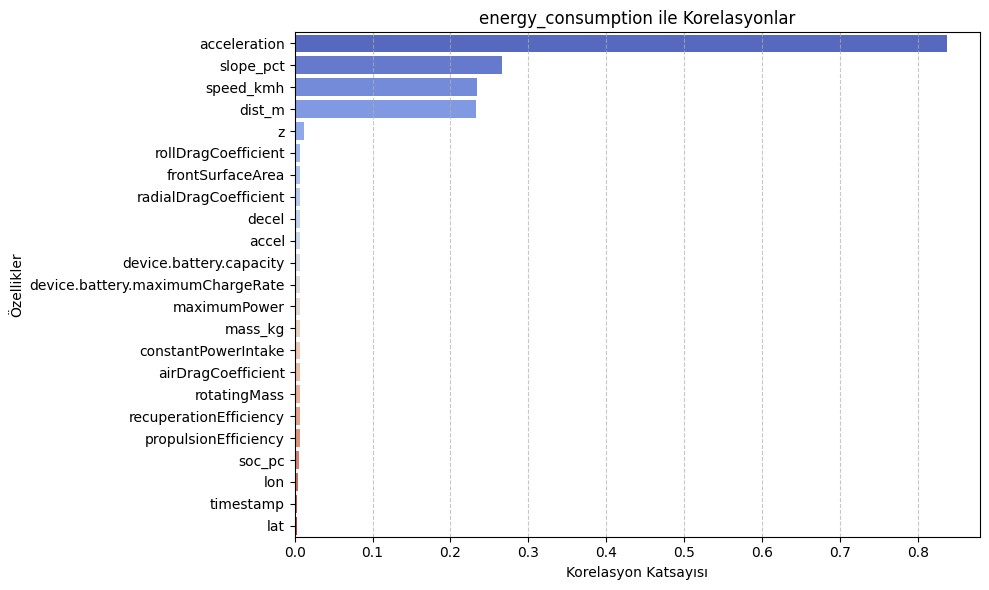

Energy Consumption ile Korelasyonlar (Yüksekten düşüğe):

acceleration                        0.837663
slope_pct                           0.265546
speed_kmh                           0.233642
dist_m                              0.232822
z                                   0.011874
rollDragCoefficient                 0.006899
frontSurfaceArea                    0.006743
radialDragCoefficient               0.006743
decel                               0.006734
accel                               0.006734
device.battery.capacity             0.006728
device.battery.maximumChargeRate    0.006728
maximumPower                        0.006728
mass_kg                             0.006727
constantPowerIntake                 0.006724
airDragCoefficient                  0.006716
rotatingMass                        0.006689
recuperationEfficiency              0.006629
propulsionEfficiency                0.006577
soc_pc                              0.006179
lon                                 0.0048

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Korelasyonları hesapla
correlations = df.corr(numeric_only=True)["energy_consumption"].drop("energy_consumption")

# Mutlak değere göre büyükten küçüğe sırala
correlations_sorted = correlations.reindex(correlations.abs().sort_values(ascending=False).index)

# Barplot olarak görselleştir
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations_sorted.values, y=correlations_sorted.index, palette="coolwarm")
plt.title("energy_consumption ile Korelasyonlar")
plt.xlabel("Korelasyon Katsayısı")
plt.ylabel("Özellikler")
plt.grid(True, axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Sayısal çıktıyı da yazdır
print("Energy Consumption ile Korelasyonlar (Yüksekten düşüğe):\n")
print(correlations_sorted)


ORTAK Feature Engineering Blok (Tüm Modeller için)

In [5]:
import numpy as np

# 1. slope_pct filtrele (±50 sınırı dışında kalanları at)
df = df[(df["slope_pct"] < 50) & (df["slope_pct"] > -50)]

# 2. energy_consumption < -100 → NaN (aşırı negatif rejenerasyonlar)
df.loc[df["energy_consumption"] < -100, "energy_consumption"] = np.nan

# 3. Eksik slope_pct → 0 (eğim verisi yoksa "düz" kabul edilir)
df["slope_pct"] = df["slope_pct"].fillna(0)

# 4. Ivme ayrımı → acc_pos (pozitif) / acc_neg (negatif frenleme)
df["acc_pos"] = df["acceleration"].clip(lower=0)
df["acc_neg"] = (-df["acceleration"]).clip(lower=0)

# 5. Hız dönüşümü (m/s ve kareli hali)
df["speed_ms"] = df["speed_kmh"] / 3.6
df["v2"] = df["speed_ms"] ** 2

# 6. Aerodinamik: CdA = Cd * A
df["CdA"] = df["airDragCoefficient"] * df["frontSurfaceArea"]


In [6]:
feature_cols = [
    "v2",                      # hızın karesi (kinetik enerji ile ilişkili)
    "acc_pos", "acc_neg",       # hızlanma / frenleme ,  enerji tüketimi & rejenerasyon
    "slope_pct",                # yol eğimi
    "mass_kg", "CdA", "rollDragCoefficient",   # araç fiziği
    "propulsionEfficiency", "recuperationEfficiency",  # # enerji verimliliği
    "maximumPower"      # motorun max gücü
]
feature_cols = [col for col in feature_cols if col in df.columns]  # emin olmak için

In [7]:
# NaN varsa düşür (özellikle hedef değişkende olabilir)
df_nn = df[feature_cols + ["energy_consumption", "vehicle_id"]].dropna()

X = df_nn[feature_cols].copy()
y = df_nn["energy_consumption"].copy()
groups = df_nn["vehicle_id"].copy()


In [8]:
from sklearn.model_selection import GroupShuffleSplit

def group_split(X, y, groups, test_size=0.15, val_size=0.15, rs=42):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=rs)
    i_tr, i_te = next(gss.split(X, y, groups))
    gss2 = GroupShuffleSplit(n_splits=1, test_size=val_size/(1-test_size), random_state=rs)
    j_tr, j_val = next(gss2.split(X.iloc[i_tr], y.iloc[i_tr], groups.iloc[i_tr]))

    tr_idx = X.iloc[i_tr].index[j_tr]
    val_idx = X.iloc[i_tr].index[j_val]
    te_idx = X.index[i_te]
    return tr_idx, val_idx, te_idx

train_idx, val_idx, test_idx = group_split(X, y, groups)

X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_val,   y_val   = X.loc[val_idx],   y.loc[val_idx]
X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]


In [9]:
from sklearn.preprocessing import MinMaxScaler

# X için ölçekleme
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

# Y için de ölçekleme Çıkış verisi için de ayrı ölçekleme yapılır çünkü sinir ağı regresyon çıktısını da küçük değerlere yakın bekler

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled   = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1, 1))

# PyTorch tensörleri float32 tipini bekler, bu yüzden dönüşüm yapılır.
X_train_np = X_train_scaled.astype(np.float32)
X_val_np   = X_val_scaled.astype(np.float32)
X_test_np  = X_test_scaled.astype(np.float32)

y_train_np = y_train_scaled.astype(np.float32)
y_val_np   = y_val_scaled.astype(np.float32)
y_test_np  = y_test_scaled.astype(np.float32)

Model, Loss, Optimizer ve Eğitim Döngüsü

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Veriler PyTorch için uygun tensör formatına getirilir.
train_dataset = TensorDataset(torch.from_numpy(X_train_np), torch.from_numpy(y_train_np))
val_dataset   = TensorDataset(torch.from_numpy(X_val_np), torch.from_numpy(y_val_np))
test_dataset  = TensorDataset(torch.from_numpy(X_test_np), torch.from_numpy(y_test_np))

# Veri setleri batch’lere bölünerek verimli eğitim yapılır. Shuffle=True : öğrenme karışık sırayla olur, overfitting azaltır.
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Sinir Ağı Modeli

In [11]:
# Giriş boyutuna göre ilk katman 64 nöron içeriyor, bu da modelin yüksek kapasiteye sahip olmasını sağlar.
# Aktivasyon fonksiyonu olarak ReLU seçildi çünkü hesaplaması hızlı ve vanishing gradient sorununa dayanıklı.
# Çıkış katmanı 1 nöron içerir çünkü regresyon problemi çözülmektedir (tek değer tahmini).
class EnergyNet(nn.Module):
    def __init__(self, input_dim):
        super(EnergyNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64), # 1. gizli katman
            nn.ReLU(),
            nn.Linear(64, 32), # 2. gizli katman (ara boyutlandırma)
            nn.ReLU(),
            nn.Linear(32, 1) # Çıkış katmanı (regresyon çıktısı)
        )

    def forward(self, x):
        return self.model(x)

# Model nesnesi giriş boyutuna göre oluşturulur.
input_dim = X_train_np.shape[1]
model = EnergyNet(input_dim)


Eğitim Süreci

In [12]:
criterion = nn.MSELoss() # Kayıp fonksiyonu: Ortalama Kare Hata (MSE), regresyon problemlerinde standarttır.

optimizer = optim.Adam(model.parameters(), lr=1e-3) # Optimizasyon algoritması Adam seçildi çünkü öğrenme oranını adaptif ayarlayarak daha hızlı ve kararlı öğrenme sağlar.

epochs = 100
best_val_loss = float('inf') # En iyi (en düşük) validation kaybı tutulur

# Eğitim döngüsü
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    # Doğrulama verisi ile modelin genelleme yeteneği test edilir
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    # Gerekirse erken durdurma uygulanabilir. Burada: En iyi validation sonucu alınan modeli kaydet.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()


Epoch 1/100 | Train Loss: 0.0009 | Val Loss: 0.0002
Epoch 2/100 | Train Loss: 0.0002 | Val Loss: 0.0002
Epoch 3/100 | Train Loss: 0.0002 | Val Loss: 0.0002
Epoch 4/100 | Train Loss: 0.0002 | Val Loss: 0.0002
Epoch 5/100 | Train Loss: 0.0002 | Val Loss: 0.0002
Epoch 6/100 | Train Loss: 0.0002 | Val Loss: 0.0002
Epoch 7/100 | Train Loss: 0.0001 | Val Loss: 0.0002
Epoch 8/100 | Train Loss: 0.0001 | Val Loss: 0.0002
Epoch 9/100 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 10/100 | Train Loss: 0.0001 | Val Loss: 0.0002
Epoch 11/100 | Train Loss: 0.0001 | Val Loss: 0.0002
Epoch 12/100 | Train Loss: 0.0001 | Val Loss: 0.0002
Epoch 13/100 | Train Loss: 0.0001 | Val Loss: 0.0002
Epoch 14/100 | Train Loss: 0.0001 | Val Loss: 0.0002
Epoch 15/100 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 16/100 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 17/100 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 18/100 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 19/100 | Train Loss: 0.0001 | Val Loss: 0.0002
Ep

Test ve Gerçek Dünya Metrikleri (Scale Geri Alınarak)

In [15]:
# Eğitim sonrası en iyi doğrulama başarımına sahip model geri yüklenir
model.load_state_dict(best_model_state)
model.eval()

# Test verisi ile tahmin yapılır
with torch.no_grad():
    y_pred_scaled = model(torch.from_numpy(X_test_np)).numpy()

# Ölçek geri alınmalı. Tahminler orijinal skala'ya geri dönüştürülür
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_np)

# Model performansı değerlendirilir
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"\nNeural Network (Test Set)")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.3f}")



Neural Network (Test Set)
MAE : 1.34
RMSE: 2.77
R²  : 0.967


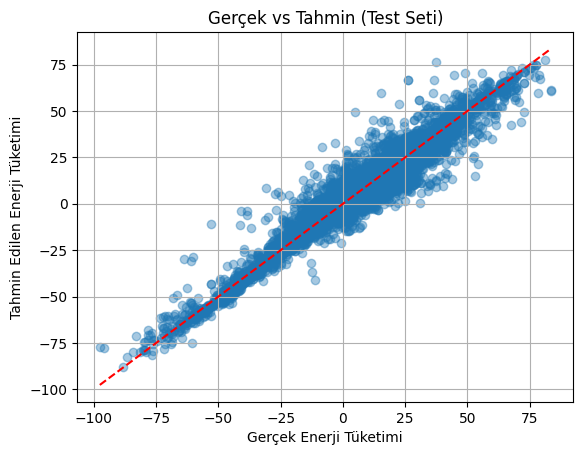

In [17]:
import matplotlib.pyplot as plt

plt.scatter(y_true, y_pred, alpha=0.4)
plt.xlabel("Gerçek Enerji Tüketimi")
plt.ylabel("Tahmin Edilen Enerji Tüketimi")
plt.title("Gerçek vs Tahmin (Test Seti)")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.grid(True)
plt.show()


Yapay Sinir Ağı modellerinde doğrudan feature importance elde etmek klasik modellerdeki gibi (örneğin RandomForest, XGBoost) kolay değildir, çünkü YSA'lar içsel olarak daha “black-box” yapıdadır. Ancak yine de özellik önemini (feature importance) çıkarabileceğimiz bir yöntem :
Permutation Importance

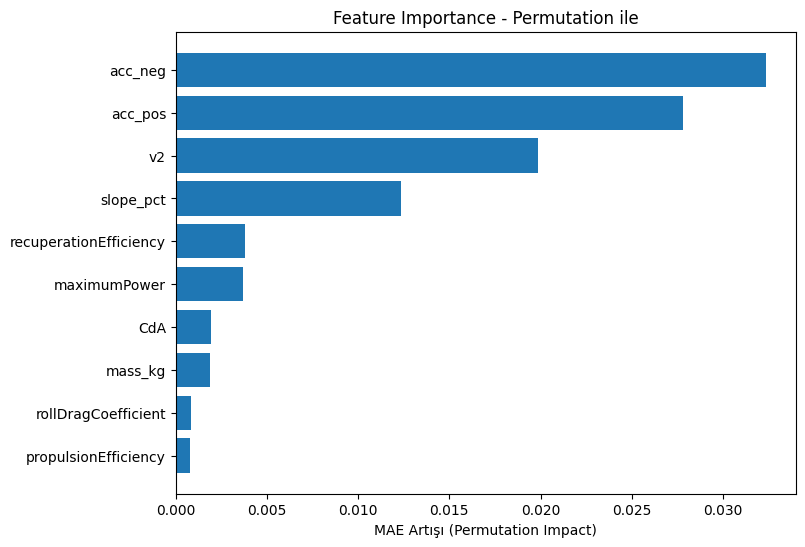

In [18]:
from sklearn.metrics import mean_absolute_error
import numpy as np

baseline_mae = mean_absolute_error(y_test_np, model(torch.from_numpy(X_test_np)).detach().numpy())
importances = []

for i in range(X_test_np.shape[1]):
    X_temp = X_test_np.copy()
    np.random.shuffle(X_temp[:, i])  # i. özelliği karıştır
    y_perm = model(torch.from_numpy(X_temp)).detach().numpy()
    permuted_mae = mean_absolute_error(y_test_np, y_perm)
    importances.append(permuted_mae - baseline_mae)

# Özellik isimleri ile eşleştir
importance_dict = dict(zip(X.columns, importances))
sorted_importance = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

# Görselleştir
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.barh(list(sorted_importance.keys()), list(sorted_importance.values()))
plt.xlabel("MAE Artışı (Permutation Impact)")
plt.title("Feature Importance - Permutation ile")
plt.gca().invert_yaxis()
plt.show()
